In [1]:
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
import json

from plot_utils import utils as plot_utils
from models import utils as model_utils

2024-01-12 16:40:05.188303: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 16:40:05.188329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 16:40:05.188345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 16:40:05.192657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 16:40:05.642797: W tensorflow/compiler/

## Load Data

In [2]:
WINDOW_SIZE = 60
TRAIN = 'train'
TEST = 'test'
# RAW DATA
raw_train_df = pd.read_csv("/home/mdzaja/MasterThesis/artifacts/assets/AAPL/data/raw/train_1m_2018-06-19_2021-07-01.csv", index_col=0)
raw_train_df.index = pd.to_datetime(raw_train_df.index)
raw_train_X = model_utils.get_X(raw_train_df, WINDOW_SIZE)
raw_test_df = pd.read_csv("/home/mdzaja/MasterThesis/artifacts/assets/AAPL/data/raw/test_1m_2021-07-01_2021-12-31.csv", index_col=0)
raw_test_df.index = pd.to_datetime(raw_test_df.index)
raw_test_X = model_utils.get_X(raw_test_df, WINDOW_SIZE)
# FEATURED DATA
feat_train_df = pd.read_csv("/home/mdzaja/MasterThesis/artifacts/assets/AAPL/data/feat/train_1m_2018-06-19_2021-07-01.csv", index_col=0)
feat_train_df.index = pd.to_datetime(feat_train_df.index)
feat_train_X = model_utils.get_X(feat_train_df, WINDOW_SIZE)
feat_test_df = pd.read_csv("/home/mdzaja/MasterThesis/artifacts/assets/AAPL/data/feat/test_1m_2021-07-01_2021-12-31.csv", index_col=0)
feat_test_df.index = pd.to_datetime(feat_test_df.index)
feat_test_X = model_utils.get_X(feat_test_df, WINDOW_SIZE)
# LABELS
with open("/home/mdzaja/MasterThesis/artifacts/assets/AAPL/labels/all_labels_train_1m_2018-06-19_2021-07-01.pkl", 'rb') as file:
    labels_train_dict = pickle.load(file)
Y_train_dict = {}
for label_name in labels_train_dict.keys():
    Y_train_dict[label_name] = model_utils.get_Y(labels_train_dict[label_name], WINDOW_SIZE)
with open("/home/mdzaja/MasterThesis/artifacts/assets/AAPL/labels/all_labels_test_1m_2021-07-01_2021-12-31.pkl", 'rb') as file:
    labels_test_dict = pickle.load(file)
Y_test_dict = {}
for label_name in labels_test_dict.keys():
    Y_test_dict[label_name] = model_utils.get_Y(labels_test_dict[label_name], WINDOW_SIZE)
# WEIGHTS
with open("/home/mdzaja/MasterThesis/artifacts/assets/AAPL/weights/all_weights_train_1m_2018-06-19_2021-07-01.pkl", 'rb') as file:
    weights_train_dict = pickle.load(file)
with open("/home/mdzaja/MasterThesis/artifacts/assets/AAPL/weights/all_weights_test_1m_2021-07-01_2021-12-31.pkl", 'rb') as file:
    weights_test_dict = pickle.load(file)

## Data Presentation

In [3]:
def print_data_info(data_df):
    print(f'\tShape: {data_df.shape}')
    start_date = data_df.index[0].strftime('%Y-%m-%d %H:%M:%S')
    end_date = data_df.index[-1].strftime('%Y-%m-%d %H:%M:%S')
    print(f'\tDates from {start_date} to {end_date}')

print('RAW DATA')
print(f'\tColumns:\n\t{", ".join(raw_train_df.columns.tolist())}')

print('Raw TRAIN data')
print_data_info(raw_train_df)

print(f'Raw TEST data')
print_data_info(raw_test_df)

print('=====================================================================================================')

print('FEATURED DATA')
print(f'\tColumns:\n\t{", ".join(feat_train_df.columns.tolist())}')

print('Featured TRAIN data')
print_data_info(feat_train_df)

print(f'Featured TEST data')
print_data_info(feat_test_df)

RAW DATA
	Columns:
	Open, High, Low, Close, Volume
Raw TRAIN data
	Shape: (297204, 5)
	Dates from 2018-06-19 10:53:00 to 2021-07-01 13:55:00
Raw TEST data
	Shape: (49533, 5)
	Dates from 2021-07-01 13:58:00 to 2021-12-31 15:59:00
FEATURED DATA
	Columns:
	Open, High, Low, Close, Volume, Returns, Volatility, Max_Drawdown, Max_Drawup, Volume_Change, Returns.1, Volatility.1, Max_Drawdown.1, Max_Drawup.1, Volume_Change.1, ADX, APO, CCI, DX, MFI, RSI, ULTOSC, WILLR, NATR, Alpha, Beta, Index_Returns, Index_Volatility, Correlation, Covariance, Beta_Direct, TF_Max_Drawdown, TF_Max_Drawup, Return_Skewness, Return_Kurtosis, Asset_To_Index_Alpha, Asset_To_Index_Beta, sin_Day_of_Week, cos_Day_of_Week, sin_Day_of_Month, cos_Day_of_Month, sin_Day_of_Year, cos_Day_of_Year, sin_time_of_day, cos_time_of_day
Featured TRAIN data
	Shape: (297204, 45)
	Dates from 2018-06-19 10:53:00 to 2021-07-01 13:55:00
Featured TEST data
	Shape: (49533, 45)
	Dates from 2021-07-01 13:58:00 to 2021-12-31 15:59:00


## Label Plots

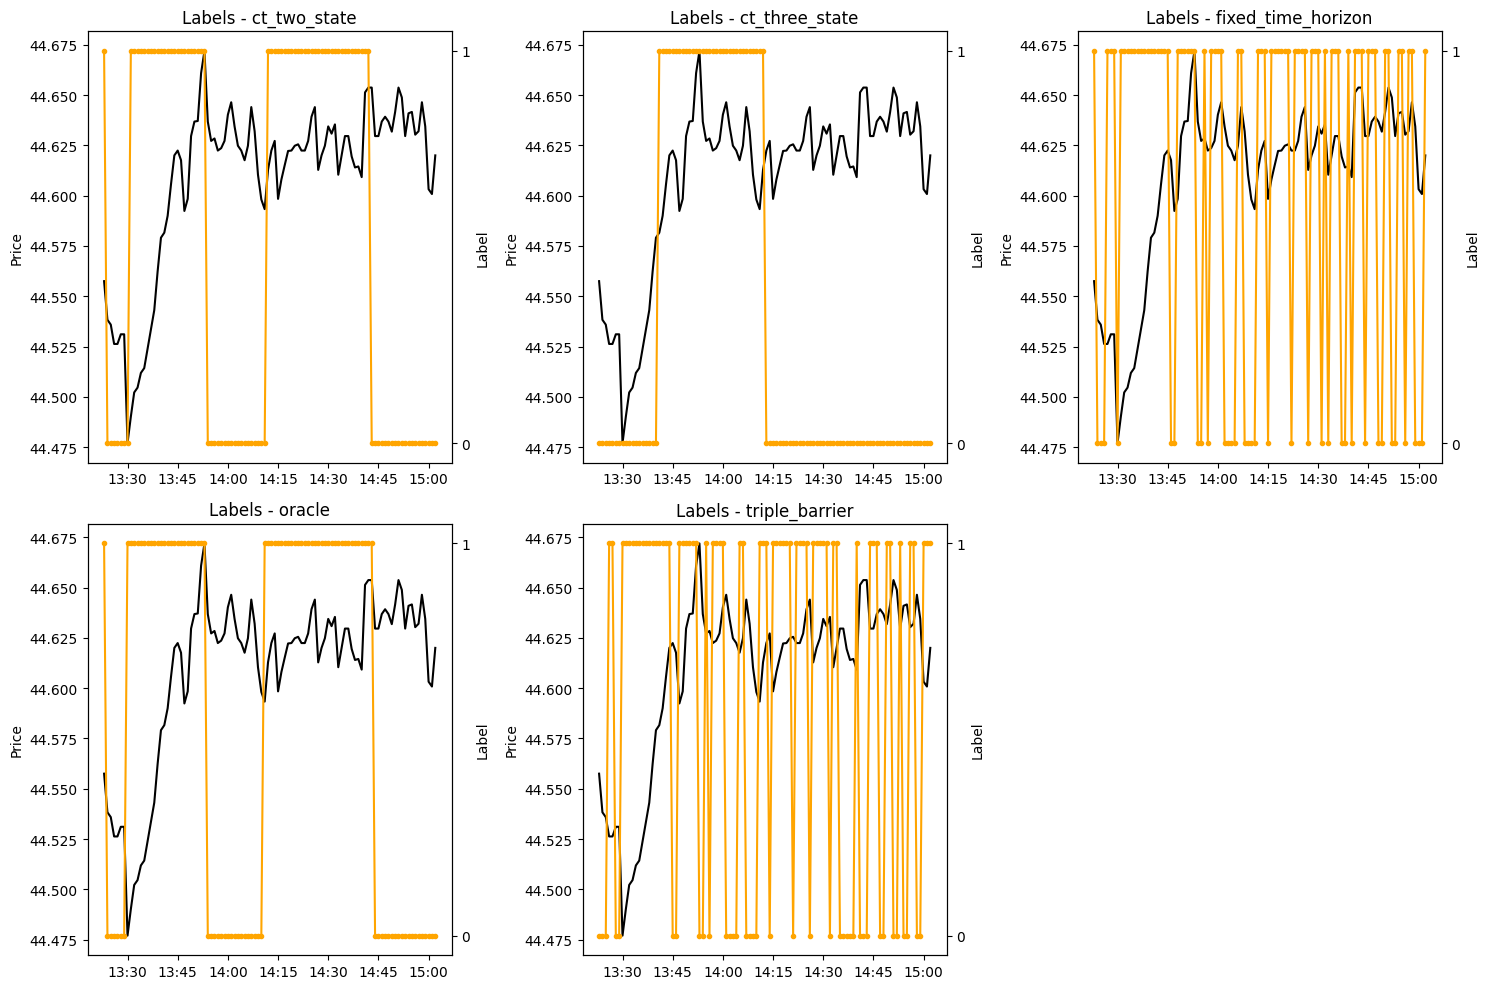

In [4]:
start_index = 150
end_index = 250
prices = raw_train_df['Close'].iloc[start_index:end_index]
labels_dict = {}
for label_name in labels_train_dict.keys():
    labels_dict[label_name] = labels_train_dict[label_name][start_index:end_index]

plot_utils.plot_labels('Labels', prices, labels_dict)

## Weight Plots

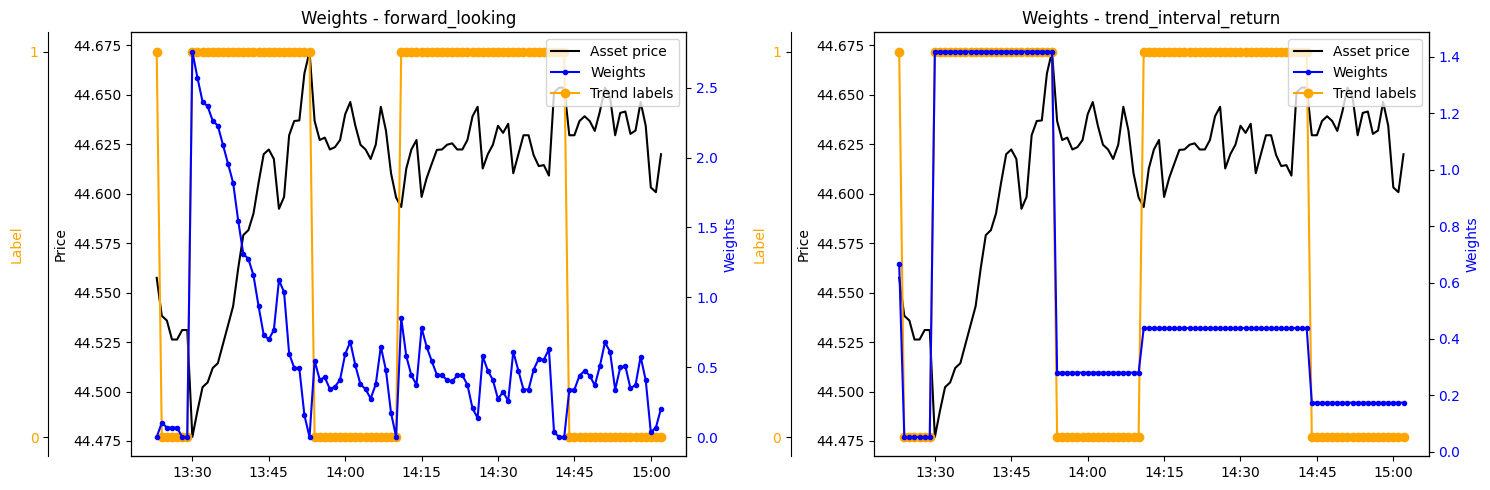

In [5]:
start_index = 150
end_index = 250
prices = raw_train_df['Close'].iloc[start_index:end_index]
labels = labels_train_dict['oracle'].iloc[start_index:end_index]
weights_dict = {}
for weight_alg, weights in weights_train_dict['oracle'].items():
    if weight_alg in ['trend_interval_return', 'forward_looking']:
        weights_dict[weight_alg] = weights.iloc[start_index:end_index]

plot_utils.plot_weights('Weights', prices, labels, weights_dict)

## Accuracy - AUC Plots

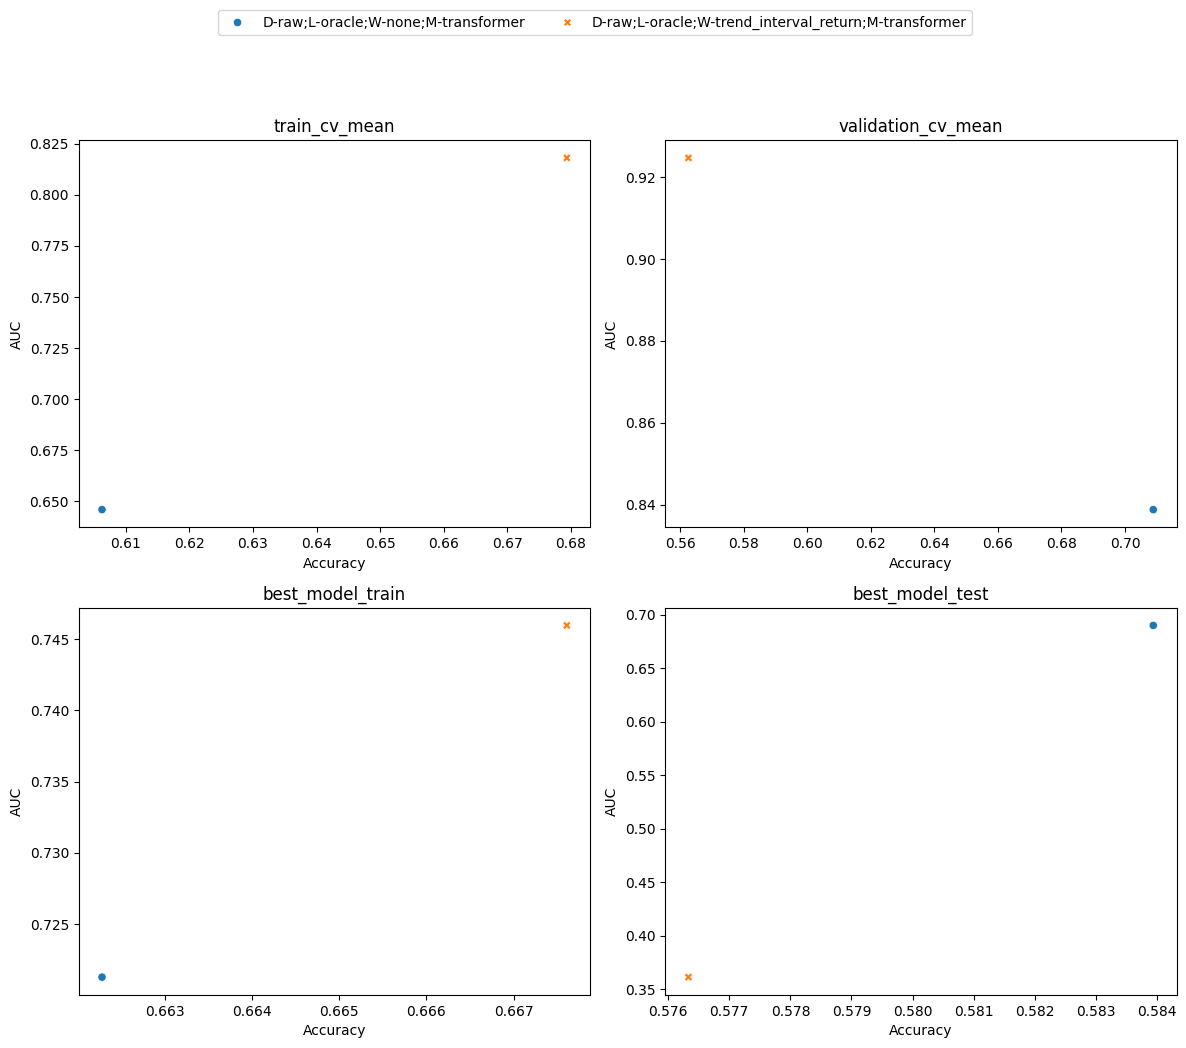

DataFrame for best_model_train:
+----------+------------+--------+-------------+---------+-----------------------+
|      AUC |   Accuracy | Data   | Model       | Label   | Weight                |
|----------+------------+--------+-------------+---------+-----------------------|
| 0.745958 |   0.667612 | raw    | transformer | oracle  | trend_interval_return |
| 0.72127  |   0.662273 | raw    | transformer | oracle  | none                  |
+----------+------------+--------+-------------+---------+-----------------------+
DataFrame for best_model_test:
+----------+------------+--------+-------------+---------+-----------------------+
|      AUC |   Accuracy | Data   | Model       | Label   | Weight                |
|----------+------------+--------+-------------+---------+-----------------------|
| 0.689917 |   0.583942 | raw    | transformer | oracle  | none                  |
| 0.361505 |   0.576331 | raw    | transformer | oracle  | trend_interval_return |
+----------+------------

In [6]:
with open('/home/mdzaja/MasterThesis/artifacts/models/test_logs/oracle-transformer/metrics.json', 'r') as file:
    metrics = json.load(file)
data_types = ['train_cv_mean', 'validation_cv_mean', 'best_model_train', 'best_model_test']
plot_utils.plot_acc_auc(metrics, x_title='Accuracy', y_title='AUC', x_key='accuracy', y_key='auc', data_types=data_types)

## ROC AUC Curve Plots

In [7]:
model1 = load_model("/home/mdzaja/MasterThesis/artifacts/models/test_logs/oracle-transformer/saved_models/raw-oracle-none-transformer.keras")
model2 = load_model("/home/mdzaja/MasterThesis/artifacts/models/test_logs/oracle-transformer/saved_models/raw-oracle-trend_interval_return-transformer.keras")

y_prob_dict = {
    'raw-oracle-none-transformer': {
        'label_name': 'oracle',
        'probs': model1.predict(raw_train_X).flatten(),
    },
    'raw-oracle-trend_interval_return-transformer': {
        'label_name': 'oracle',
        'probs': model2.predict(raw_train_X).flatten(),
    }
}
plot_utils.plot_roc_auc_curves(Y_train_dict, y_prob_dict, 'ROC AUC curves - train')

y_prob_dict = {
    'raw-oracle-none-transformer': {
        'label_name': 'oracle',
        'probs': model1.predict(raw_test_X).flatten(),
    },
    'raw-oracle-trend_interval_return-transformer': {
        'label_name': 'oracle',
        'probs': model2.predict(raw_test_X).flatten(),
    }
}
plot_utils.plot_roc_auc_curves(Y_test_dict, y_prob_dict, 'ROC AUC curves - test')

2024-01-12 16:40:10.995056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 16:40:10.995567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 16:40:11.006956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ValueError: in user code:

    File "/home/mdzaja/installations/miniconda3/envs/mt/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/mdzaja/installations/miniconda3/envs/mt/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mdzaja/installations/miniconda3/envs/mt/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/mdzaja/installations/miniconda3/envs/mt/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/mdzaja/installations/miniconda3/envs/mt/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filedo1393z_.py", line 24, in tf__call
        ag__.for_stmt(ag__.ld(self).transformer_blocks, None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'transformer_block'})
    File "/tmp/__autograph_generated_filedo1393z_.py", line 22, in loop_body
        x = ag__.converted_call(ag__.ld(transformer_block), (ag__.ld(x),), None, fscope)

    ValueError: Exception encountered when calling layer 'custom_transformer' (type CustomTransformer).
    
    in user code:
    
        File "/home/mdzaja/MasterThesis/models/transformer.py", line 77, in call  *
            x = transformer_block(x)
        File "/home/mdzaja/installations/miniconda3/envs/mt/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/home/mdzaja/installations/miniconda3/envs/mt/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 60, 11), found shape=(None, 60, 5)
    
    
    Call arguments received by layer 'custom_transformer' (type CustomTransformer):
      • inputs=tf.Tensor(shape=(None, 60, 5), dtype=float32)


## Backtest Results

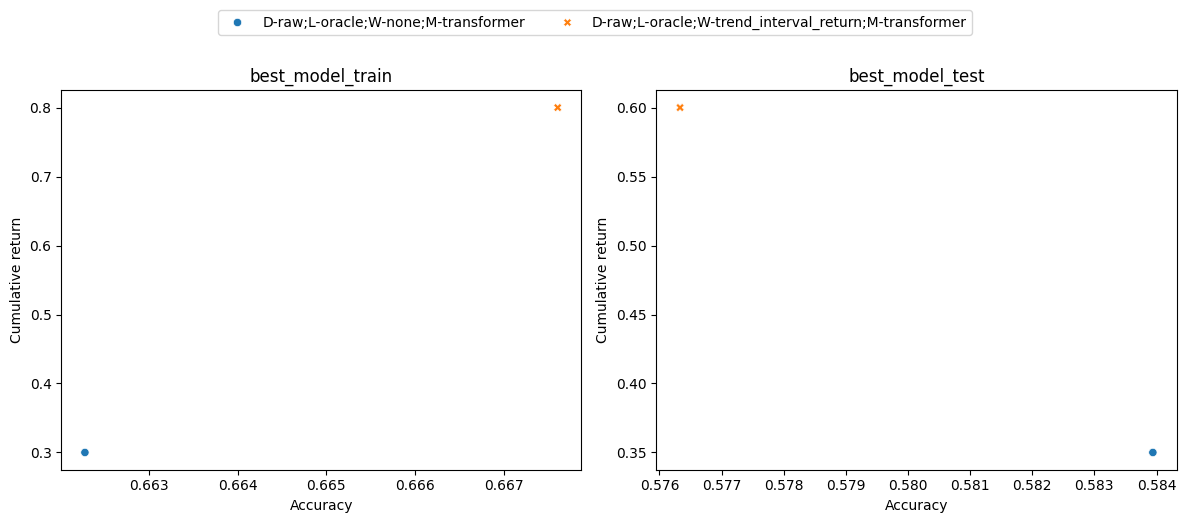

DataFrame for best_model_train:
+---------------------+------------+--------+-------------+---------+-----------------------+
|   Cumulative return |   Accuracy | Data   | Model       | Label   | Weight                |
|---------------------+------------+--------+-------------+---------+-----------------------|
|                 0.8 |   0.667612 | raw    | transformer | oracle  | trend_interval_return |
|                 0.3 |   0.662273 | raw    | transformer | oracle  | none                  |
+---------------------+------------+--------+-------------+---------+-----------------------+
DataFrame for best_model_test:
+---------------------+------------+--------+-------------+---------+-----------------------+
|   Cumulative return |   Accuracy | Data   | Model       | Label   | Weight                |
|---------------------+------------+--------+-------------+---------+-----------------------|
|                0.6  |   0.576331 | raw    | transformer | oracle  | trend_interval_return

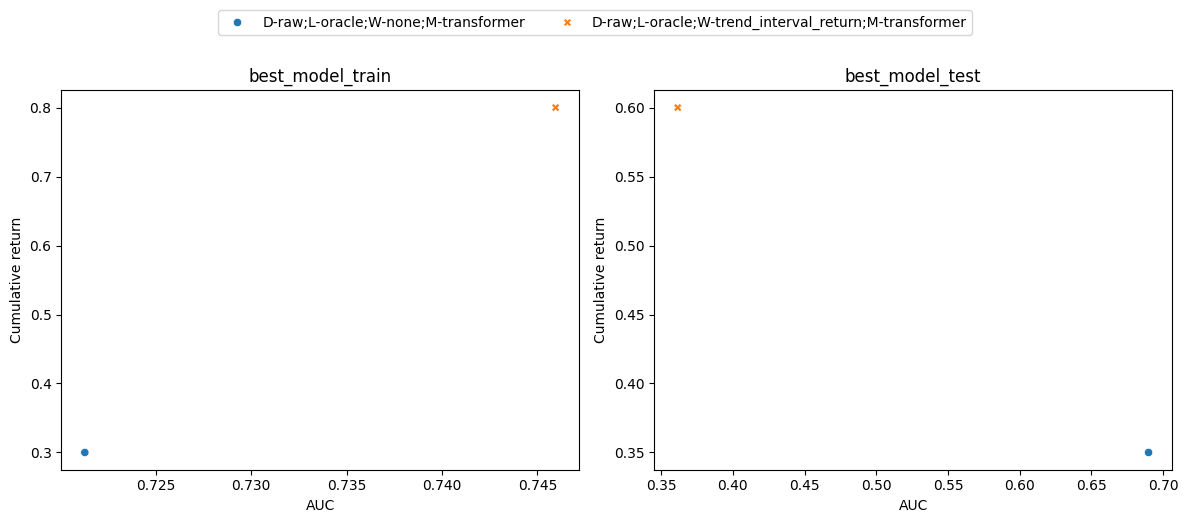

DataFrame for best_model_train:
+---------------------+----------+--------+-------------+---------+-----------------------+
|   Cumulative return |      AUC | Data   | Model       | Label   | Weight                |
|---------------------+----------+--------+-------------+---------+-----------------------|
|                 0.8 | 0.745958 | raw    | transformer | oracle  | trend_interval_return |
|                 0.3 | 0.72127  | raw    | transformer | oracle  | none                  |
+---------------------+----------+--------+-------------+---------+-----------------------+
DataFrame for best_model_test:
+---------------------+----------+--------+-------------+---------+-----------------------+
|   Cumulative return |      AUC | Data   | Model       | Label   | Weight                |
|---------------------+----------+--------+-------------+---------+-----------------------|
|                0.6  | 0.361505 | raw    | transformer | oracle  | trend_interval_return |
|                

In [ ]:
with open('/home/mdzaja/MasterThesis/artifacts/models/test_logs/oracle-transformer/metrics.json', 'r') as file:
    metrics = json.load(file)
data_types = ['best_model_train', 'best_model_test']
plot_utils.plot_acc_auc(metrics, x_title='Accuracy', y_title='Cumulative return', x_key='accuracy', y_key='cumulative_return', data_types=data_types)
plot_utils.plot_acc_auc(metrics, x_title='AUC', y_title='Cumulative return', x_key='auc', y_key='cumulative_return', data_types=data_types)